#To begin with stock market portfolio optimization, we need to gather data on stock market performance over time.
#I am collecting real-time stock market data using the yfinance API.

In [3]:
pip install yfinance --upgrade --no-cache-dir

In [4]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

#Time Period of the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today()-timedelta(days=365)).strftime("%Y-%m-%d")

tickers = ['RELIANCE.NS','TCS.NS','INFY.NS','HDFCBANK.NS']

data = yf.download(tickers, start=start_date, end=end_date,progress=False)
#Index to bring date into columns
data=data.reset_index()
#Melting the data
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])
#Pivot the dataframe to have Open,high,low as columns
data_pivoted = data_melted.pivot_table(index=['Date','Ticker'],columns='Attribute',values='value', aggfunc='first')

stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute       Date       Ticker    Adj Close        Close         High  \
0         2023-07-17  HDFCBANK.NS  1656.282715  1678.900024  1682.000000   
1         2023-07-17      INFY.NS  1396.894409  1422.949951  1458.949951   
2         2023-07-17  RELIANCE.NS  2572.266846  2581.353271  2598.290283   
3         2023-07-17       TCS.NS  3432.684326  3491.699951  3549.899902   
4         2023-07-18  HDFCBANK.NS  1654.901611  1677.500000  1704.000000   

Attribute          Low         Open      Volume  
0          1633.000000  1650.000000  24626464.0  
1          1414.300049  1425.949951  11569884.0  
2          2517.943115  2535.480225  11110020.0  
3          3477.050049  3510.000000   2743228.0  
4          1670.000000  1698.000000  40538409.0  


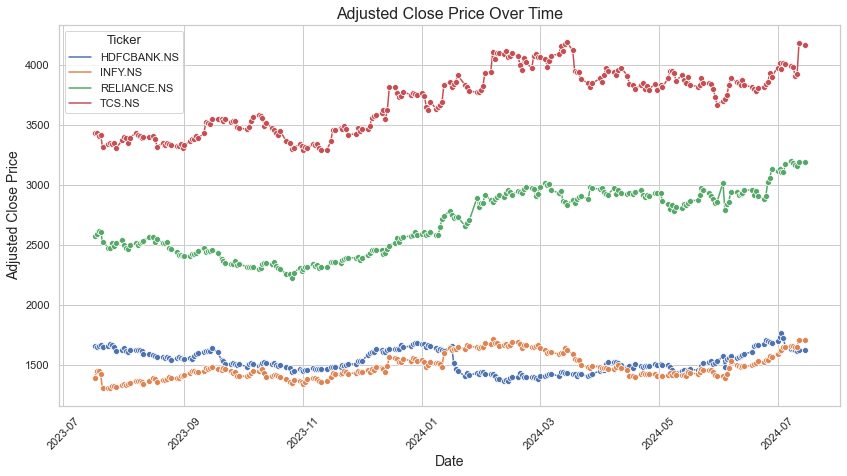

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data.set_index('Date', inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')
#Line plot over time 2023 to 2024
sns.lineplot(data=stock_data, x='Date', y='Adj Close', hue='Ticker', marker='o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

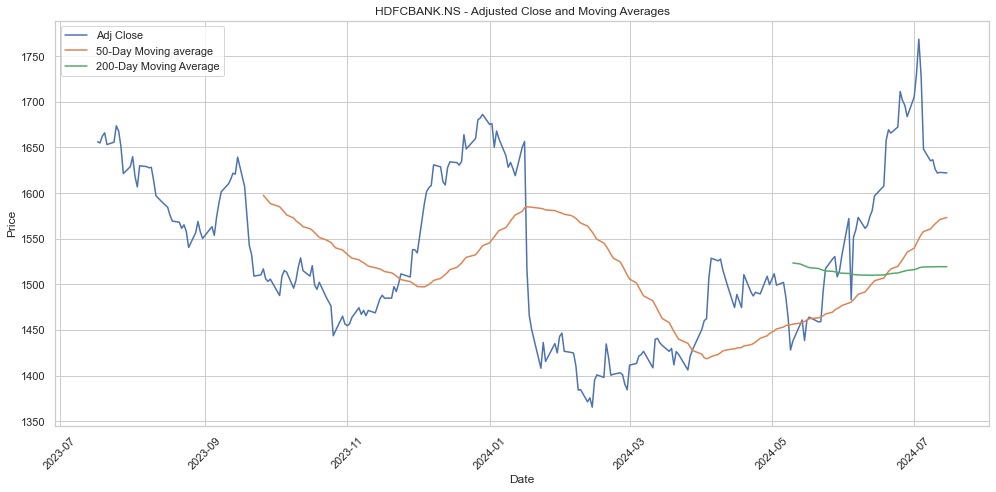

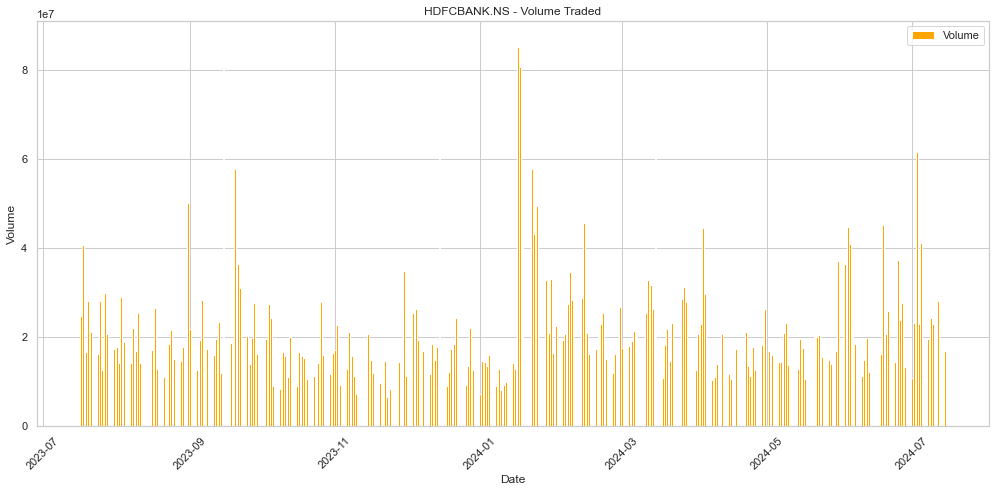

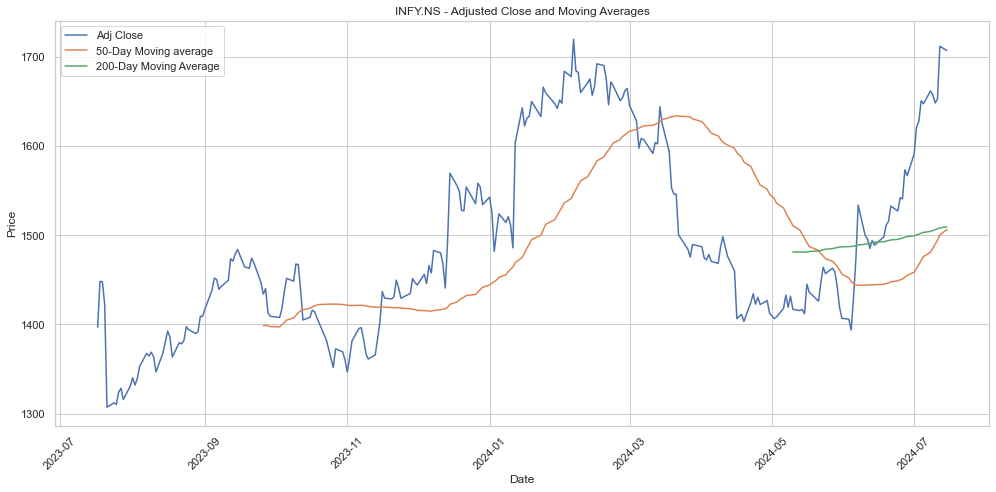

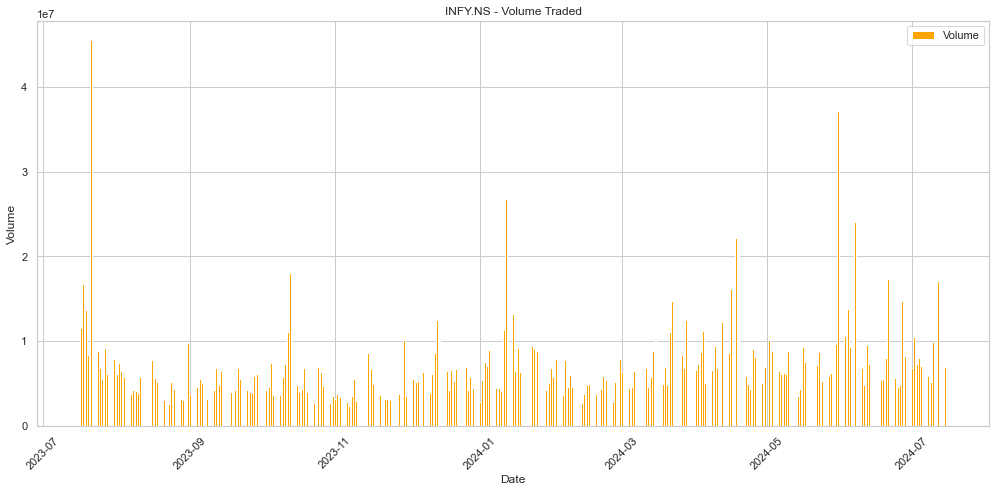

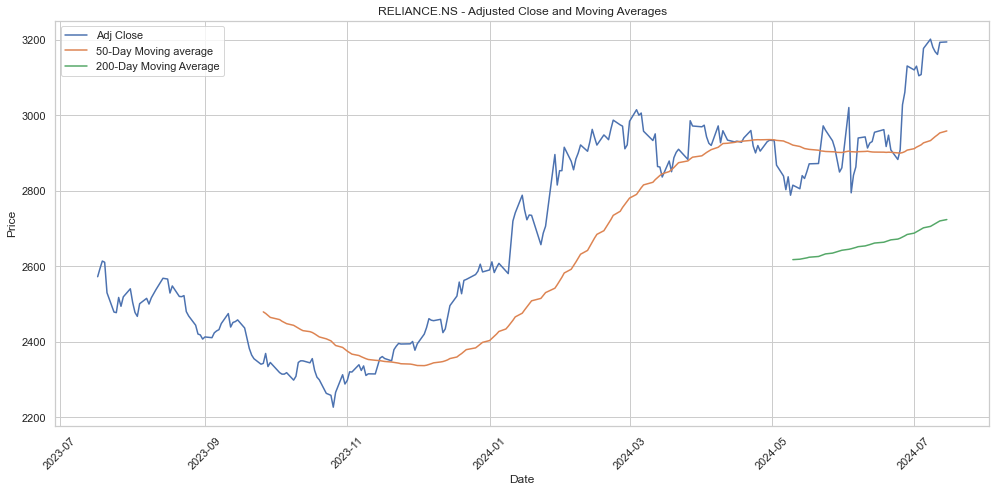

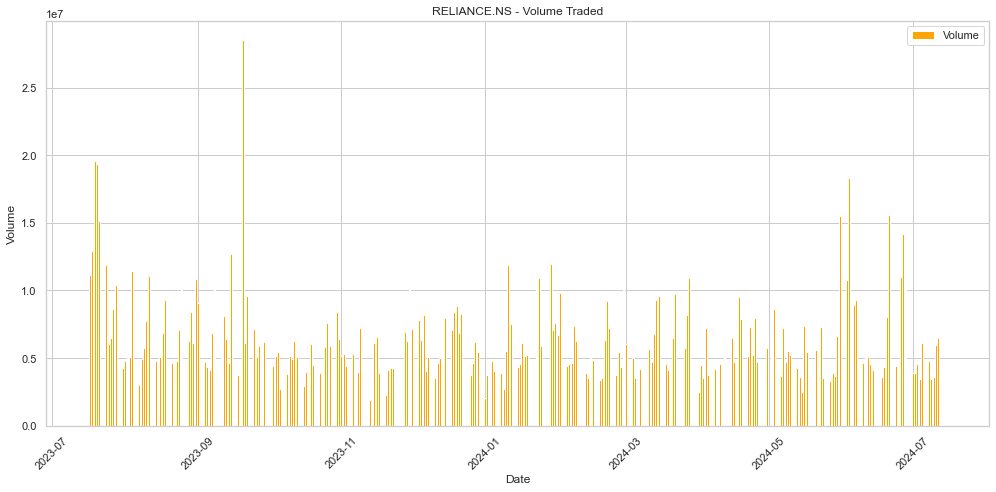

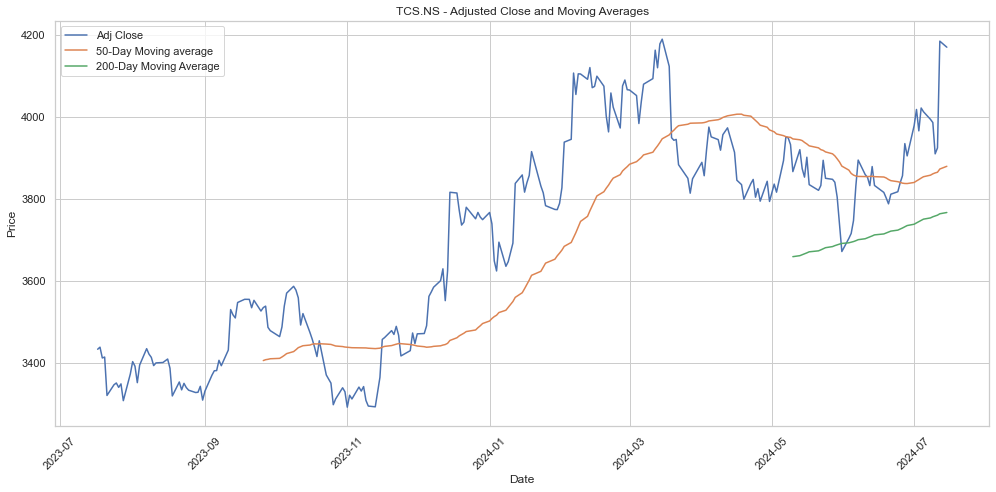

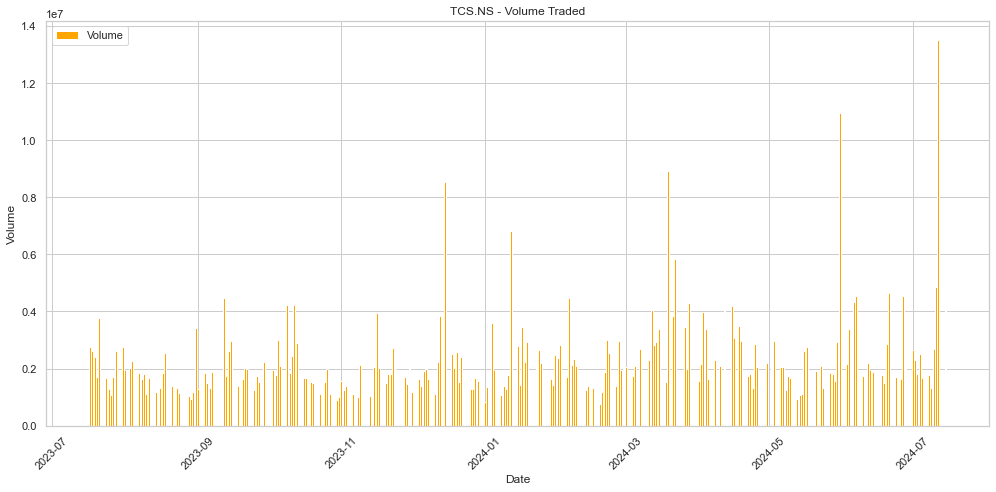

In [29]:
#Visualizing the stocks adjuested close prices along with 50-day and 200-day moving averages to understand both short term and long term trends.
#Trading vloume - to provide context about the stock's trading activity over time.

short_window = 50 #50-day moving average is technical indicator that calculates the average closing price of a stock over last 50 trading days
long_window = 200 #200-day moving average is technical indicator that calculates the average closing price of a stock over last 200 trading days


#Get Unique tickers
unique_tickers = stock_data['Ticker'].unique()

#Iterate over each unique ticker
for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker']==ticker].copy()
    
    #Calculating rolling mean
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()
    
    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Adj Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day Moving average')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label='200-Day Moving Average')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

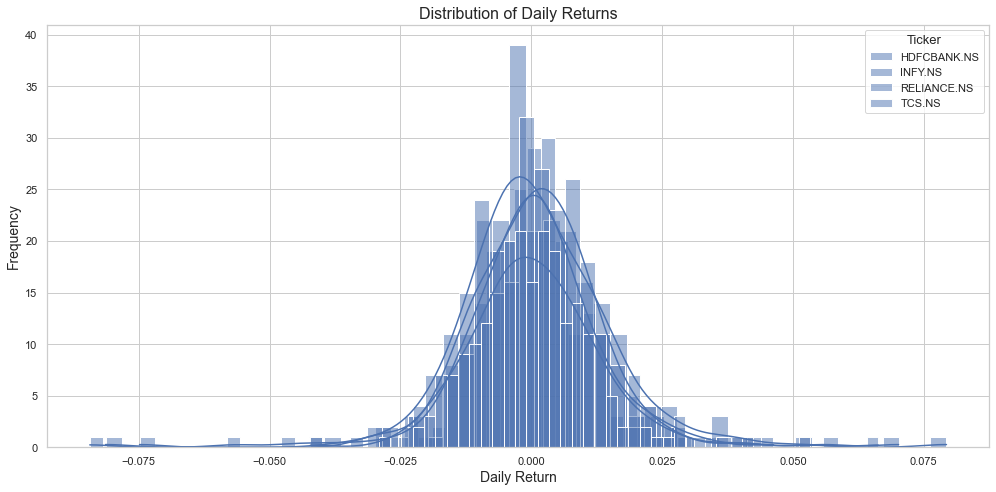

In [39]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

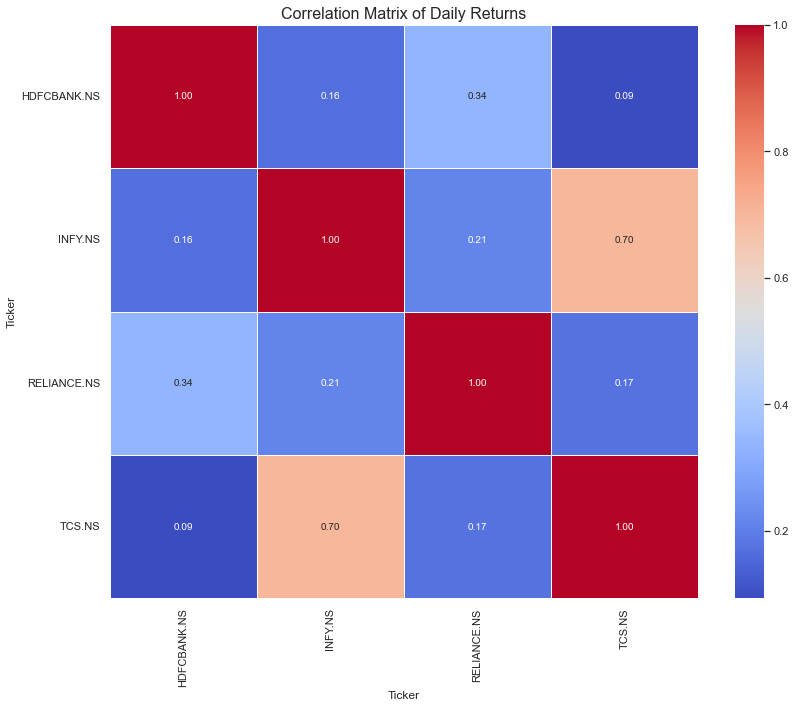

In [42]:
#Correlation between stock's:

daily_returns = stock_data.pivot_table(index='Date',columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidth=.5, fmt='.2f', annot_kws={"size":10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#There is high positive correlation of 0.71 for INFS & TCS which indicates that they tend to move in same direction.
#Reliance shows low correlation with INFY(0.21) and TCS(0.17).
#HDFCBANK has a moderate positive correlation with Reliance(0.34) and a low correlation with INFY(0.16) and TCS(0.09).
#Varying correlation suggest potential diversification benefits; combining stocks with lower correlations can reduce overall portfolio risk

# Portfolio Optimization

In [47]:
# Using Modern Portfolio Theory, we can construct an efficient portfolio by balancing risk and return.
# 1.Calculating the expected returns and Variance for each stock:
import numpy as np
#Annualizing returns and Variance
expected_returns = daily_returns.mean()*252
variance = daily_returns.std()*np.sqrt(252)

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Variance' : variance
})
stock_stats

,Expected Return,Variance
Ticker,,
HDFCBANK.NS,0.000875,0.211285
INFY.NS,0.234249,0.229741
RELIANCE.NS,0.246670,0.209952
TCS.NS,0.221661,0.201231


#RELIANCE has highest expected return(24.66%) and moderate variance(20.99%) which means high reward investment with higher risk.
#INFY, TCS also have high expected returns(23.42%,22.16% Resp.) with moderate variance.
#HDFCBANK has lowest expected return(0.08%) and variance(21.12%) which makes it the least attractive in terms of risk-adjusted returns.

C:\Users\Sahana\AppData\Local\Temp\ipykernel_2544\759935063.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe Ratio')


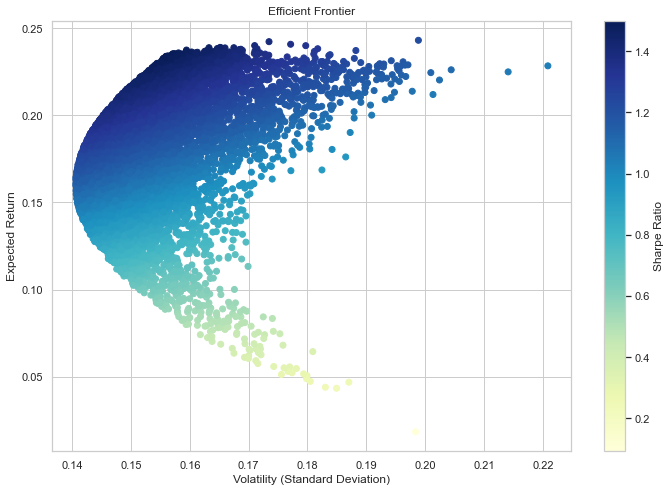

In [53]:
# Function to calculate portfolio performance
def portfolio_perf(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_var = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_var

num_portfolios = 10000  # Number of portfolios to simulate
results = np.zeros((3, num_portfolios))  # Arrays to store the results
cov_matrix = daily_returns.cov() * 252  # Annualized covariance matrix
np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)
    
    portfolio_return, portfolio_var = portfolio_perf(weights, expected_returns, cov_matrix)
    
    results[0, i] = portfolio_return
    results[1, i] = portfolio_var
    results[2, i] = portfolio_return / portfolio_var  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

#Dot = portfolio
#Color = Sharpe ratio, a measure of rist-adjusted return.
#Portfolios on the leftmost edge of the frontier (closer to the y-axis) offer the highest expected returns for a given level of variance, which represent optimal portfolios.
#Darker blue provide better risk-adjusted returns.

In [55]:
# 3. To identify the ortfolio with the maximum sharpe ratio:

max_sharpe_index = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_index]
max_sharpe_var = results[1, max_sharpe_index]
max_sharpe_ratio = results[2, max_sharpe_index]

max_sharpe_return, max_sharpe_var, max_sharpe_ratio
#Max sharpe ratio has the following characteristics:
#Expected returns ~ 23.38%
#Variance ~ 15.59%
#Sharpe Ratio ~ 1.499

(0.2338564686648153, 0.15596504284155444, 1.4994159229795558)

In [57]:
# 4.Identifying the weights of the stocks in the portfolio that yield the max sharpe ratio:

max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)
    
    portfolio_return, portfolio_var = portfolio_perf(weights, expected_returns, cov_matrix)
    
    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights=weights
        break
    
portfolio_weights_df = pd.DataFrame({
    'Ticker':unique_tickers,
    'Weight':max_sharpe_weights
})
    
portfolio_weights_df

,Ticker,Weight
0,HDFCBANK.NS,0.490421
1,INFY.NS,0.348798
2,RELIANCE.NS,0.035306
3,TCS.NS,0.125475


#HDFCBANK(49.04%) has the highest allocation, which indicates its significant contribution to the portfolio's performance.
#While RELIANCE(3.53%) has the smallest allocation.
#This balanced allocationaims to maximize returns while minimizing risks by leveraging individual stock performances and their correlations.

# SUMMARY
#This is how the stock market portfolio optimization works. Stock market portfolio optimization involves:
#Analysing price trends
#Calculation expected returns & variance
#Determining the correlations b/w different stocks to acheive diversifications.